In [1]:
import copy, itertools, json, os, pickle, re, sys, time

In [2]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import scipy.io as sio
from scipy import special
from scipy import signal as sig
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata
from scipy.spatial.distance import jensenshannon, pdist, squareform, hamming
import scipy.stats as stats
from sklearn.decomposition import PCA

In [3]:
import tensorflow as tf
tfk = tf.keras
tfki = tf.keras.initializers
tfkl = tf.keras.layers
tfkm = tf.keras.models
tfko = tf.keras.optimizers
tfkr = tf.keras.regularizers
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.keras.metrics import categorical_crossentropy as CCE
import tensorflow.keras.backend as K

In [4]:
aa_babel = {
  "alphabet": "ARNDCQEGHILKMFPSTWYV-",
  "tri_alphabet": [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL", "GAP"
  ]
}
aa_babel["a2i"] = {a: i for i, a in enumerate(aa_babel["alphabet"])}
aa_babel["i2a"] = {i: a for i, a in enumerate(aa_babel["alphabet"])}
aa_babel["tri2a"] = dict(zip(aa_babel["tri_alphabet"], aa_babel["alphabet"]))
aa_babel["tri2i"] = {aaa: i for i, aaa in enumerate(aa_babel["tri_alphabet"])}

In [5]:
plt.style.use("default")
_fig_dir = "/home/jupyter-dylan/figures/"
_src_dir = "/home/jupyter-dylan/data/BLAT_ECOLX/"

________________________________________________________________________________________________________________________________________

Methods

________________________________________________________________________________________________________________________________________

In [6]:
def contact_AUC(pred, meas, thresh=0.01):
  """# pred. contacts vs. % correct wrt "thresh" CON-FIND score"""
  # ensure comparison validity
  assert pred.shape == meas.shape, "shape mismatch"
  # evaluated i, j indices greater than 6 aa 1-D distance
  eval_idx = np.triu_indices_from(meas, 6)
  # extract contacts at relevant indices
  pred_, meas_ = pred[eval_idx], meas[eval_idx] 
  # top "L" predicted contact bins
  L = (np.linspace(0.1, 1.0, 10)*len(meas)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  return np.mean([(meas_[sort_idx[:l]]>thresh).mean() for l in L])

In [7]:
def cce(p, q):
  """categorical cross entropy"""
  return -(p*np.log(q+1e-8)).sum((1, 2))

In [8]:
def lae(N, L, A, enc=(512, 512), lat=32, dec=(512, 512), l2=0.1):
  """Linear Auto-Encoder"""

  def _loss(p, q):
    """pseudo-likelihood"""
    return K.sum(K.categorical_crossentropy(p, q), -1)

  # clear graph, parameters
  K.clear_session()
  P = {"activation": "linear", "use_bias": False}
  l2 = (l2/N)*(L-1)*(A-1)/2
  P["kernel_regularizer"] = tfkr.l2(l2)

  # encoder (E)
  Ei = tfkl.Input((L, A))
  E = tfkl.Flatten()(Ei)
  for e in enc: E = tfkl.Dense(e, **P)(E)
  # latent (Z)
  Z = tfkl.Dense(lat, **P)(E)
  # decoder (D)
  Di = tfkl.Input((lat,))
  D = Di
  for d in dec: D = tfkl.Dense(d, **P)(D)
  D = tfkl.Dense(L*A, **P)(D)
  D = tfkl.Reshape((L, A))(D)
  Do = tfkl.Activation("softmax")(D)

  # collate, define, compile
  EZ = tfkm.Model(Ei, Z, name="Z")
  Dio = tfkm.Model(Di, Do, name="Dio")
  models = {
    "Z": EZ,
    "ZD": tfkm.Model(Ei, Dio(EZ(Ei)))
  }
  models["ZD"].compile("adam", _loss)
  return models

In [9]:
def make_msa(seqs, a2i, gap=.5, Neff=.8):
  """construct Multiple Sequence Alignment (MSA)"""
  raw = np.array([[a2i[a] for a in seq] for seq in seqs])  
  non_gap = np.where(np.mean((raw==a2i["-"]).astype(np.float), 0)<gap)[0]
  # non-gapped columns, raw msa, effective sequence weights
  return {
    "X_ng": non_gap,
    "X": np.eye(len(a2i))[raw],
    # calculated wrt "clean" indices
    "W": 1.0/np.sum(1.0*((1.0-squareform(pdist(raw[:, non_gap], "hamming")))>=Neff), -1)
  }

In [10]:
def mrf(X, W, use_bias=False, l2=0.01):
  """Markov Random Field"""

  def _loss(p, q):
    """pseudo-likelihood"""
    return K.sum(K.categorical_crossentropy(p, q), -1)

  def _cst_w(w):
    """constrain pairwise weights: symmetrize, set diagonal to zero"""
    w = (w+K.transpose(w))/2
    rm_I = K.constant((1-np.eye(L))[:, None, :, None], dtype=tf.float32)
    cst_w = K.reshape(w, (L, A, L, A))*rm_I
    return K.reshape(K.reshape(w, (L, A, L, A))*rm_I, (L*A, L*A))

  # clear graph, parameters
  K.clear_session()
  N, L, A = X.shape
  l2 = (l2/N)*(L-1)*(A-1)/2
  P = {
    "units": L*A,
    "kernel_initializer": tfki.Zeros,
    "kernel_regularizer": tfkr.l2(l2),
    "kernel_constraint": _cst_w
  }
  # model
  P["use_bias"] = use_bias
  if use_bias:
    sw = np.log((X.T*W).sum(-1).T+l2*np.log(W.sum()))
    P["bias_initializer"] = tfki.Constant(sw-sw.mean(-1, keepdims=True))
    P["bias_regularizer"] = tfkr.l2(l2/N)
  M = tfk.Sequential()
  M.add(tfkl.Flatten(input_shape=(L, A)))
  M.add(tfkl.Dense(**P))
  M.add(tfkl.Reshape((L, A)))
  M.add(tfkl.Activation("softmax"))
  
  # compile
  M.compile(tfko.Adam(0.1*np.log(W.sum())/L), _loss)
  return M

In [11]:
def pw_saliency(M):
  """keras model (M) to saliency matrix (W) in (L, A, L, A) form"""
  # placeholder for each l in L
  ph = tf.placeholder(dtype=tf.int32, shape=[])
  # model session & model output, length, amino acids
  sess, out = K.get_session(), M.output[:, ph]
  L, A = [int(s) for s in M.output.get_shape()[1:]]
  # input saliency given pseudolikelihood
  sal = -tf.gradients(-tf.reduce_sum(tf.eye(A)*tf.log(out+1e-8)), M.input)[0]
  # pairwise weights, symmetrize
  pw = np.array([sess.run(sal, {ph: l, M.input: np.zeros((A, L, A))}) for l in range(L)])
  return (pw+np.transpose(pw, (2, 3, 0, 1)))/2

In [12]:
def pw_l2(pw):
  """pw (L, A, L, A) to L2 norm form (L, L), both raw and APC"""
  # norm, remove self connection
  l2_norm = np.sqrt(np.square(pw[:, :20, :, :20]).sum((1, 3)))
  np.fill_diagonal(l2_norm, 0.0)
  # average product (~largest eigenvector)
  ap = l2_norm.sum(0)
  ap = ap[None, :]*ap[:, None]/ap.sum()
  # remove average product
  l2_norm_apc = l2_norm-ap
  np.fill_diagonal(l2_norm_apc, 0.0)
  return l2_norm, l2_norm_apc

In [13]:
def pssm(x, w=None):
  """reweighted sub-MSA PSSM"""
  if w is None: w = reweight(x)
  return ((x*w[:, None, None]).sum(0)/w.sum())[None, ...]

In [14]:
def reweight(x, Neff=0.8):
  """effective sequence weighting"""
  return 1.0/np.sum(((1.0-squareform(pdist(x.argmax(-1), "hamming"))) >= Neff).astype("float"), -1)

In [15]:
def sw_saliency(M):
  """keras model (M) to saliency matrix (b) in (L, A) form"""
  # placeholder for each l in L
  ph = tf.placeholder(dtype=tf.int32, shape=[])
  # model session & model output, length, amino acids
  sess, out = K.get_session(), M.output[:, ph]
  L, A = [int(s) for s in M.output.get_shape()[1:]]
  # input saliency given pseudolikelihood
  sal = -tf.gradients(-tf.reduce_sum(tf.eye(A)*tf.log(out+1e-8)), M.input)[0]
  # pairwise weights, symmetrize
  pw = np.array([sess.run(sal, {ph: l, M.input: np.zeros((A, L, A))}) for l in range(L)])
  return np.diagonal(pw.reshape(L*A, L*A)).reshape((L, A))

In [16]:
def vae(N, L, A, enc=(512, 512), lat=32, dec=(512, 512), drop=0.5, l2=0.0):
  """Variational Auto-Encoder"""

  def _ELBO(p, q):
    """evidence lower bound (ELBO)"""
    RC = K.sum(K.categorical_crossentropy(p, q), axis=-1)
    KL = 0.5*K.sum(K.square(Zm)+K.square(Zs)-Zlogs-1.0, axis=-1)
    return RC+KL

  # clear graph, parameters
  K.clear_session()
  P = {"activation": "selu"}
  l2 = (l2/N)*(L-1)*(A-1)/2
  P["kernel_regularizer"] = tfkr.l2(l2)

  # encoder (E)
  Ei = tfkl.Input((L, A))
  E = tfkl.Flatten()(Ei)
  for e in enc:
    E = tfkl.Dense(e, **P)(E)
    E = tfkl.Dropout(drop)(E)
    E = tfkl.BatchNormalization()(E)
  # latent (Z)
  Zm = tfkl.Dense(lat)(E)
  Zlogs = tfkl.Dense(lat)(E)
  Zs = tfkl.Lambda(lambda x: K.exp(0.5*x))(Zlogs)
  Z = tfkl.Lambda(lambda x: x[0]+x[1]*K.random_normal(K.shape(x[0])))([Zm, Zs])
  # decoder (D)
  Di = tfkl.Input((lat,))
  D = Di
  for d in dec:
    D = tfkl.Dense(d, **P)(D)
    D = tfkl.Dropout(drop)(D)
    D = tfkl.BatchNormalization()(D)
  D = tfkl.Dense(L*A, **P)(D)
  D = tfkl.Reshape((L, A))(D)
  Do = tfkl.Activation("softmax")(D)

  # collate, define, compile
  EZm = tfkm.Model(Ei, Zm, name="Zm")
  EZms = tfkm.Model(Ei, Z, name="Zms")
  Dio = tfkm.Model(Di, Do, name="Dio")
  models = {
    "Zm": EZm,
    "Zms": EZms,
    "ZDm": tfkm.Model(Ei, Dio(EZm(Ei))),
    "ZDms": tfkm.Model(Ei, Dio(EZms(Ei)))
  }
  models["ZDms"].compile("adam", _ELBO)
  return models

________________________________________________________________________________________________________________________________________

load

________________________________________________________________________________________________________________________________________

In [429]:
# alignment file
# af = "DATA_BLAT_ECOLX_1_b0.5.i90c80.a2m"
# af = "DATA_BLAT_ECOLX_1_b0.5.i100c80.a2m"
af = "DATA_BLAT_ECOLX_TEM1.i90c80.1e-20.a3m"
# af = "DATA_BLAT_ECOLX_TEM1.i100c80.1e-20.a3m"
# load
msa = np.load(_src_dir+af+".npy", allow_pickle=True).flatten()[0]
for k, v in msa.items():
  try: print(k, v.shape)
  except: print(k)

fcns (7356,)
upids (7356,)
rs (263,)
rs_ng (263,)
dX (5260, 263, 21)
dY (5260, 33)
qa (734, 13)
X_qa (734, 263, 21)
con
X_ng (257,)
X (7356, 263, 21)
W (7356,)


In [431]:
# reference sequence
rs, rs_ng = msa["rs"], msa["rs_ng"]
# cleaned one-hot seqs, effective weights
X, W = msa["X"][:, msa["X_ng"], :], msa["W"]
# num seqs, protein length
N, L = X.shape[0], X.shape[1]
# reference sequence
ref = X[0][None, :]
# DMS
dX = msa["dX"][:, msa["rs_ng"], :][:, msa["X_ng"], :]
dY = msa["dY"].copy()
# annotations: function, UniProt ID
fcns, upids = msa["fcns"], msa["upids"]
# quality annotations
X_qa = msa["X_qa"][:, msa["X_ng"], :]
qa = msa["qa"]
# hamming distance from reference
hamm = np.abs(ref-X).sum((1, 2))/2
qa_hamm = np.abs(ref-X_qa).sum((1, 2))/2
# contacts
dY["cpr"] = np.repeat((msa["con"]["1ERO"]["con"] > 0.01).sum(0), 20)
con = msa["con"]["1ERO"]["con"][:, msa["rs_ng"]][msa["rs_ng"], :][:, msa["X_ng"]][msa["X_ng"], :]
# check
[print(x, eval(x).shape) for x in ["X", "W", "ref", "hamm", "dX", "dY", "fcns", "upids", "X_qa", "qa", "con"]];
# [print(x, eval(x).shape) for x in ["X", "W", "ref", "hamm", "dX", "dY", "X_qa", "qa", "con"]];

X (7356, 257, 21)
W (7356,)
ref (1, 257, 21)
hamm (7356,)
dX (5260, 257, 21)
dY (5260, 34)
fcns (7356,)
upids (7356,)
X_qa (734, 257, 21)
qa (734, 13)
con (257, 257)


In [19]:
# X = np.concatenate([X, X_qa])
# W = reweight(X)

________________________________________________________________________________________________________________________________________

MRF

________________________________________________________________________________________________________________________________________

In [432]:
%%time
# MRF parameters, init, train
MRF_par = {"use_bias": "True", "l2": "0.04"}
MRF_name = "MRF|"+"|".join([i+"="+o for i, o in MRF_par.items()])
MRF = mrf(X, W, **{i: eval(o) for i, o in MRF_par.items()})
MRF.fit(X, X, N, 200, 0)
# predict / assess
MRF_p_X = MRF.predict(X)
MRF_p_dX = MRF.predict(dX)
MRF_pw_sal = pw_saliency(MRF)
MRF_pw_W = MRF.get_weights()[0]
# update results
MRF_sal_W = str(np.round(stats.pearsonr(MRF_pw_sal.reshape((L*21, L*21)).flatten(), MRF_pw_W.flatten())[0], 4))
MRF_con = pw_l2(MRF_pw_sal)[1]
MRF_conAUC = str(np.round(contact_AUC(MRF_con, con), 4))
MRF_name += "|corr_pwSal_W="+MRF_sal_W+"|conAUC="+MRF_conAUC+"|"
dY[MRF_name+"dX_p_X0"] = -cce(dX[..., :-1], MRF_p_X[0][None, ...][..., :-1])
dY[MRF_name+"dX_p_dX"] = -cce(dX[..., :-1], MRF_p_dX[..., :-1])
print(MRF_name)

MRF|use_bias=True|l2=0.04|corr_pwSal_W=0.9166|conAUC=0.8642|
CPU times: user 1min 21s, sys: 58.8 s, total: 2min 20s
Wall time: 2min 23s


________________________________________________________________________________________________________________________________________

LAE

________________________________________________________________________________________________________________________________________

In [433]:
%%time
# LAE parameters, init, train
LAE_par = {"enc": "(512,)", "lat": "2048", "dec": "(512,)", "l2": "0.01"}
LAE_name = "LAE|"+"|".join([i+"="+o for i, o in LAE_par.items()])
LAE = lae(*X.shape, **{i: eval(o) for i, o in LAE_par.items()})
for bs, e in zip(np.logspace(6, 11, 6, True, 2), 16*np.ones(8)):
  bs, e = int(bs), int(e)
  LAE["ZD"].fit(X, X, sample_weight=W, batch_size=bs, epochs=e, verbose=0)
# predict / assess
LAE_p_Z_X = LAE["Z"].predict(X)
LAE_p_Z_dX = LAE["Z"].predict(dX)
LAE_p_ZD_X = LAE["ZD"].predict(X)
LAE_p_ZD_dX = LAE["ZD"].predict(dX)
# update results
LAE_con = pw_l2(pw_saliency(LAE["ZD"]))[1]
LAE_conAUC = str(np.round(contact_AUC(LAE_con, con), 4))
LAE_name += "|conAUC="+LAE_conAUC+"|"
dY[LAE_name+"dX_p_X0"] = -cce(dX[..., :-1], LAE_p_ZD_X[0][None, ...][..., :-1])
dY[LAE_name+"dX_p_dX"] = -cce(dX[..., :-1], LAE_p_ZD_dX[..., :-1])
print(LAE_name)

LAE|enc=(512,)|lat=2048|dec=(512,)|l2=0.01|conAUC=0.8143|
CPU times: user 1min 27s, sys: 10.4 s, total: 1min 37s
Wall time: 1min 15s


________________________________________________________________________________________________________________________________________

VAE

________________________________________________________________________________________________________________________________________

In [434]:
%%time
# VAE parameters, init, train
VAE_par = {
#   "enc": "(5292,)", "lat": "10584", "dec": "(5292,)", "drop": "0.2", "l2": "0.01"
  "enc": "(512,)", "lat": "2048", "dec": "(512,)", "drop": "0.2", "l2": "0.01"
}
VAE_name = "VAE|"+"|".join([i+"="+o for i, o in VAE_par.items()])
VAE = vae(*X.shape, **{i: eval(o) for i, o in VAE_par.items()})
for bs, e in zip(np.logspace(6, 11, 6, True, 2), 16*np.ones(8)):
  bs, e = int(bs), int(e)
  VAE["ZDms"].fit(X, X, sample_weight=W, batch_size=bs, epochs=e, verbose=0)
# predict / assess
VAE_p_Zm_X = VAE["Zm"].predict(X)
VAE_p_Zm_dX = VAE["Zm"].predict(dX)
VAE_p_ZDm_X = VAE["ZDm"].predict(X)
VAE_p_ZDm_dX = VAE["ZDm"].predict(dX)
# update results
VAE_m_con = pw_l2(pw_saliency(VAE["ZDm"]))[1]
VAE_m_conAUC = str(np.round(contact_AUC(VAE_m_con, con), 4))
VAE_name += "|conAUC="+VAE_m_conAUC+"|"
dY[VAE_name+"dX_p_X0"] = -cce(dX, VAE_p_ZDm_X[0][None, ...])
dY[VAE_name+"dX_p_dX"] = -cce(dX, VAE_p_ZDm_dX)-.5*(VAE_p_Zm_dX**2).sum(-1)
print(VAE_name)

VAE|enc=(512,)|lat=2048|dec=(512,)|drop=0.2|l2=0.01|conAUC=0.5304|
CPU times: user 2min 14s, sys: 14.5 s, total: 2min 28s
Wall time: 1min 48s


# multiple models

________________________________________________________________________________________________________________________________________

high throughput

________________________________________________________________________________________________________________________________________

#### TODO:
## eval pw sal rank (equivalent for LAE, could be different for VAE)
## check if gapped included...

In [89]:
# # parameters
# L2 = np.round([i*j for j in np.logspace(-4, 0, base=10, num=5) for i in range(1, 10)], 4).astype("str")
#   # MRF
# MRF_pars = []
# for bias in ["True", "False"]:
#   for l2 in L2:
#     MRF_pars.append({"use_bias": bias, "l2": l2})
#   # LAE, VAE
# LAE_pars, VAE_pars = [], []
# for u in (L*np.array([1, 2, 4, 8])).astype("str"):
#   for l in [1, 2, 3]:
#     for z in np.logspace(1, 11, base=2, num=11).astype("int").astype("str"):
#       for l2 in L2:
#         LAE_pars.append({
#           "enc": "("+((u+", ")*l).rstrip(" ")+")", "lat": z, 
#           "dec": "("+((u+", ")*l).rstrip(" ")+")", "l2": l2
#         })
#         for d in np.round(np.linspace(0, 0.5, num=6), 3).astype("str"):
#           VAE_pars.append({
#             "enc": "("+((u+", ")*l).rstrip(" ")+")", "lat": z, 
#             "dec": "("+((u+", ")*l).rstrip(" ")+")", "l2": l2, "drop": d
#           })

In [90]:
# %%time
# # MRF
# for MRF_par in MRF_pars:
# # for MRF_par in np.random.permutation(MRF_pars)[:2]:
#   # MRF init, train
#   MRF_name = "MRF|"+"|".join([i+"="+o for i, o in MRF_par.items()])
#   MRF = mrf(X, W, **{i: eval(o) for i, o in MRF_par.items()})
#   MRF.fit(X, X, N, 200, 0)
#   # predict / assess
#   MRF_p_X = MRF.predict(X)
#   MRF_p_dX = MRF.predict(dX)
#   MRF_pw_sal = pw_saliency(MRF)
#   MRF_pw_W = MRF.get_weights()[0]
#   # update results
#   MRF_sal_W = str(np.round(stats.pearsonr(MRF_pw_sal.reshape((L*21, L*21)).flatten(), MRF_pw_W.flatten())[0], 4))
#   MRF_con = pw_l2(MRF_pw_sal)[1]
#   MRF_conAUC = str(np.round(contact_AUC(MRF_con, con), 4))
#   MRF_name += "|corr_pwSal_W="+MRF_sal_W+"|conAUC="+MRF_conAUC+"|"
#   dY[MRF_name+"dX_p_X0"] = -cce(dX, MRF_p_X[0][None, ...])
#   dY[MRF_name+"dX_p_dX"] = -cce(dX, MRF_p_dX)
#   print(MRF_name)

MRF|use_bias=True|l2=0.0001|corr_pwSal_W=0.9683|conAUC=0.7446|
MRF|use_bias=True|l2=0.0002|corr_pwSal_W=0.9641|conAUC=0.7909|
MRF|use_bias=True|l2=0.0003|corr_pwSal_W=0.9605|conAUC=0.8199|
MRF|use_bias=True|l2=0.0004|corr_pwSal_W=0.9575|conAUC=0.8358|
MRF|use_bias=True|l2=0.0005|corr_pwSal_W=0.9547|conAUC=0.8438|
MRF|use_bias=True|l2=0.0006|corr_pwSal_W=0.9523|conAUC=0.8465|
MRF|use_bias=True|l2=0.0007|corr_pwSal_W=0.95|conAUC=0.8508|
MRF|use_bias=True|l2=0.0008|corr_pwSal_W=0.9479|conAUC=0.8504|
MRF|use_bias=True|l2=0.0009|corr_pwSal_W=0.946|conAUC=0.8528|
MRF|use_bias=True|l2=0.001|corr_pwSal_W=0.9443|conAUC=0.8563|
MRF|use_bias=True|l2=0.002|corr_pwSal_W=0.932|conAUC=0.8617|
MRF|use_bias=True|l2=0.003|corr_pwSal_W=0.9247|conAUC=0.8603|
MRF|use_bias=True|l2=0.004|corr_pwSal_W=0.9199|conAUC=0.8584|
MRF|use_bias=True|l2=0.005|corr_pwSal_W=0.9165|conAUC=0.8598|
MRF|use_bias=True|l2=0.006|corr_pwSal_W=0.9139|conAUC=0.864|
MRF|use_bias=True|l2=0.007|corr_pwSal_W=0.9118|conAUC=0.8648|
MRF|

In [173]:
# %%time
# # LAE
# # for LAE_par in LAE_pars:
# for LAE_par in np.random.permutation(LAE_pars)[:200]:
#   # LAE init, train
#   LAE_name = "LAE|"+"|".join([i+"="+o for i, o in LAE_par.items()])
#   LAE = lae(*X.shape, **{i: eval(o) for i, o in LAE_par.items()})
#   for bs, e in zip(np.logspace(6, 11, 6, True, 2), 16*np.ones(8)):
#     bs, e = int(bs), int(e)
#     LAE["ZD"].fit(X, X, sample_weight=W, batch_size=bs, epochs=e, verbose=0)
#   # predict / assess
#   LAE_p_ZD_X = LAE["ZD"].predict(X)
#   LAE_p_ZD_dX = LAE["ZD"].predict(dX)
#   # update results
#   LAE_con = pw_l2(pw_saliency(LAE["ZD"]))[1]
#   LAE_conAUC = str(np.round(contact_AUC(LAE_con, con), 4))
#   LAE_name += "|conAUC="+LAE_conAUC+"|"
#   dY[LAE_name+"dX_p_X0"] = -cce(dX, LAE_p_ZD_X[0][None, ...])
#   dY[LAE_name+"dX_p_dX"] = -cce(dX, LAE_p_ZD_dX)
#   print(LAE_name)

LAE|enc=(504, 504, 504,)|lat=32|dec=(504, 504, 504,)|l2=0.001|conAUC=0.0893|
LAE|enc=(252, 252,)|lat=2|dec=(252, 252,)|l2=1.0|conAUC=0.0341|
LAE|enc=(504, 504,)|lat=4|dec=(504, 504,)|l2=1.0|conAUC=0.0341|
LAE|enc=(252, 252, 252,)|lat=128|dec=(252, 252, 252,)|l2=1.0|conAUC=0.0932|
LAE|enc=(504, 504, 504,)|lat=128|dec=(504, 504, 504,)|l2=0.01|conAUC=0.5393|
LAE|enc=(1008, 1008, 1008,)|lat=64|dec=(1008, 1008, 1008,)|l2=0.001|conAUC=0.1758|
LAE|enc=(1008, 1008,)|lat=64|dec=(1008, 1008,)|l2=0.0001|conAUC=0.0522|
LAE|enc=(252,)|lat=2048|dec=(252,)|l2=0.1|conAUC=0.4862|
LAE|enc=(2016, 2016, 2016,)|lat=2048|dec=(2016, 2016, 2016,)|l2=0.01|conAUC=0.0544|
LAE|enc=(252,)|lat=2048|dec=(252,)|l2=0.001|conAUC=0.6668|
LAE|enc=(252, 252,)|lat=128|dec=(252, 252,)|l2=0.1|conAUC=0.4727|
LAE|enc=(1008, 1008,)|lat=2|dec=(1008, 1008,)|l2=0.0001|conAUC=0.0251|
LAE|enc=(252, 252,)|lat=128|dec=(252, 252,)|l2=0.0001|conAUC=0.1397|
LAE|enc=(252,)|lat=2048|dec=(252,)|l2=0.01|conAUC=0.7029|
LAE|enc=(252, 252,)|lat

In [174]:
# %%time
# # VAE
# # for VAE_par in VAE_pars:
# for VAE_par in np.random.permutation(VAE_pars)[:200]:
#   # VAE init, train
#   VAE_name = "VAE|"+"|".join([i+"="+o for i, o in VAE_par.items()])
#   VAE = vae(*X.shape, **{i: eval(o) for i, o in VAE_par.items()})
#   for bs, e in zip(np.logspace(6, 11, 6, True, 2), 16*np.ones(8)):
#     bs, e = int(bs), int(e)
#     VAE["ZDms"].fit(X, X, sample_weight=W, batch_size=bs, epochs=e, verbose=0)
#   # predict / assess
#   VAE_p_Zm_X = VAE["Zm"].predict(X)
#   VAE_p_Zm_dX = VAE["Zm"].predict(dX)
#   VAE_p_ZDm_X = VAE["ZDm"].predict(X)
#   VAE_p_ZDm_dX = VAE["ZDm"].predict(dX)
#   # update results
#   VAE_m_con = pw_l2(pw_saliency(VAE["ZDm"]))[1]
#   VAE_m_conAUC = str(np.round(contact_AUC(VAE_m_con, con), 4))
#   VAE_name += "|conAUC="+VAE_m_conAUC+"|"
#   dY[VAE_name+"dX_p_X0"] = -cce(dX, VAE_p_ZDm_X[0][None, ...])
#   dY[VAE_name+"dX_p_dX"] = -cce(dX, VAE_p_ZDm_dX)-.5*(VAE_p_Zm_dX**2).sum(-1)
#   print(VAE_name)

VAE|enc=(2016,)|lat=4|dec=(2016,)|l2=0.01|drop=0.1|conAUC=0.0459|
VAE|enc=(252, 252,)|lat=64|dec=(252, 252,)|l2=0.0001|drop=0.1|conAUC=0.0421|
VAE|enc=(504, 504,)|lat=2|dec=(504, 504,)|l2=0.01|drop=0.2|conAUC=0.0538|
VAE|enc=(1008, 1008, 1008,)|lat=64|dec=(1008, 1008, 1008,)|l2=1.0|drop=0.5|conAUC=0.0333|
VAE|enc=(252, 252,)|lat=128|dec=(252, 252,)|l2=0.01|drop=0.1|conAUC=0.035|
VAE|enc=(504, 504, 504,)|lat=32|dec=(504, 504, 504,)|l2=0.1|drop=0.5|conAUC=0.0581|
VAE|enc=(504, 504,)|lat=512|dec=(504, 504,)|l2=0.0001|drop=0.3|conAUC=0.052|
VAE|enc=(2016, 2016, 2016,)|lat=16|dec=(2016, 2016, 2016,)|l2=0.1|drop=0.1|conAUC=0.0297|
VAE|enc=(1008, 1008,)|lat=8|dec=(1008, 1008,)|l2=0.01|drop=0.0|conAUC=0.0191|
VAE|enc=(2016, 2016, 2016,)|lat=256|dec=(2016, 2016, 2016,)|l2=0.1|drop=0.5|conAUC=0.083|
VAE|enc=(504, 504,)|lat=8|dec=(504, 504,)|l2=1.0|drop=0.0|conAUC=0.1136|
VAE|enc=(252,)|lat=4|dec=(252,)|l2=0.0001|drop=0.0|conAUC=0.0121|
VAE|enc=(504,)|lat=1024|dec=(504,)|l2=0.0001|drop=0.2|conAUC

________________________________________________________________________________________________________________________________________

dissect HT

________________________________________________________________________________________________________________________________________

In [450]:
# HT correlations
C = dY[dY["hamm_wrt_X_ng"] == 1].corr("spearman").round(3)
meas = [
  "R_amp_avg_39", "R_amp_avg_156", "R_amp_avg_625", "R_amp_avg_2500", "R_cefo",
  "P_amp_ddG_stat", "T_amox_MIC_score", "O_amp_linear"
]
ds_pred = ["ds_sw", "ds_pw", "ds_v1", "ds_v2", "ds_v3", "ds_v4", "ds_v5", "ds_vEns"]
benchmarks = dict(zip(meas+ds_pred, np.abs(C[meas+ds_pred].loc[meas+ds_pred]["R_amp_avg_2500"].values)))

In [451]:
# MRF
mC = C.loc[[c for c in C.columns if c.startswith("MRF")]][meas]
mC["dX_p_"] = np.array([x.split("_")[-1] for x in mC.index])
mC["bias"] = np.array([x.split("|")[1].split("=")[1] for x in mC.index])
mC["l2"] = np.array([float(x.split("|")[2].split("=")[1]) for x in mC.index])
mC["conAUC"] = np.array([float(x.split("|")[-2].split("=")[1]) for x in mC.index])
# LAE
lC = C.loc[[c for c in C.columns if c.startswith("LAE")]][meas]
lC["dX_p_"] = np.array([x.split("_")[-1] for x in lC.index])
lC["ED"] = np.array([x.split("|")[1].split("=")[1] for x in lC.index])
lC["lat"] = np.array([int(x.split("|")[2].split("=")[1]) for x in lC.index])
lC["l2"] = np.array([float(x.split("|")[4].split("=")[1]) for x in lC.index])
lC["conAUC"] = np.array([float(x.split("|")[-2].split("=")[1]) for x in lC.index])
# VAE
vC = C.loc[[c for c in C.columns if c.startswith("VAE")]][meas]
vC["dX_p_"] = np.array([x.split("_")[-1] for x in vC.index])
vC["ED"] = np.array([x.split("|")[1].split("=")[1] for x in vC.index])
vC["lat"] = np.array([int(x.split("|")[2].split("=")[1]) for x in vC.index])
vC["l2"] = np.array([float(x.split("|")[4].split("=")[1]) for x in vC.index])
vC["drop"] = np.array([float(x.split("|")[5].split("=")[1]) for x in vC.index])
vC["conAUC"] = np.array([float(x.split("|")[-2].split("=")[1]) for x in vC.index])

In [206]:
vC[vC["conAUC"]>0.65]

,R_amp_avg_39,R_amp_avg_156,R_amp_avg_625,R_amp_avg_2500,R_cefo,P_amp_ddG_stat,T_amox_MIC_score,O_amp_linear,dX_p_,ED,lat,l2,drop,conAUC
"VAE|enc=(2016,)|lat=1024|dec=(2016,)|l2=0.01|drop=0.5|conAUC=0.6623|dX_p_X0",0.268,0.435,0.602,0.740,-0.063,-0.520,0.722,0.744,X0,"(2016,)",1024,0.01,0.5,0.6623
"VAE|enc=(2016,)|lat=1024|dec=(2016,)|l2=0.01|drop=0.5|conAUC=0.6623|dX_p_dX",0.281,0.445,0.610,0.744,-0.066,-0.514,0.719,0.748,dX,"(2016,)",1024,0.01,0.5,0.6623
"VAE|enc=(1008,)|lat=256|dec=(1008,)|l2=0.1|drop=0.1|conAUC=0.6701|dX_p_X0",0.244,0.418,0.577,0.723,-0.092,-0.515,0.705,0.724,X0,"(1008,)",256,0.10,0.1,0.6701
"VAE|enc=(1008,)|lat=256|dec=(1008,)|l2=0.1|drop=0.1|conAUC=0.6701|dX_p_dX",0.246,0.415,0.571,0.712,-0.077,-0.510,0.697,0.714,dX,"(1008,)",256,0.10,0.1,0.6701


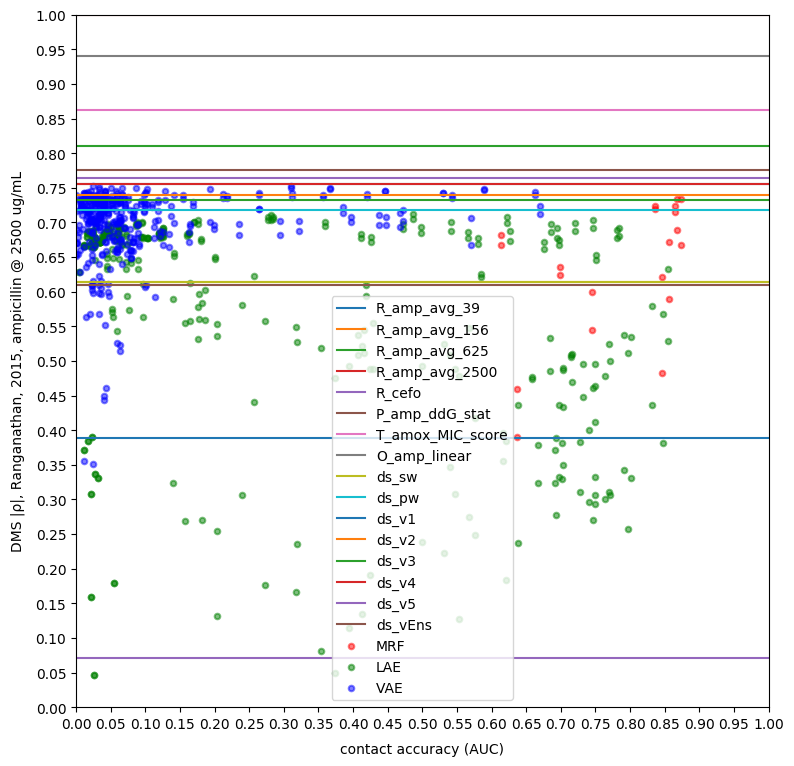

In [256]:
# parameters
_scatter = {"s": 16, "alpha": 0.5, "lw": 1.5}
# results
F, A = plt.subplots(1, 1, figsize=(8, 8))
A.scatter(mC["conAUC"].values, mC["R_amp_avg_2500"].values, label="MRF", c="r", **_scatter)
A.scatter(lC["conAUC"].values, lC["R_amp_avg_2500"].values, label="LAE", c="g", **_scatter)
A.scatter(vC["conAUC"].values, vC["R_amp_avg_2500"].values, label="VAE", c="b", **_scatter)
# context
[A.plot((0, 1), (y, y), label=x) for x, y in benchmarks.items()]
# ancillary
A.set_xlim([0, 1])
A.set_xticks(np.linspace(0, 1, num=21))
A.set_xlabel("contact accuracy (AUC)", labelpad=8)
A.set_ylim([0, 1])
A.set_yticks(np.linspace(0, 1, num=21))
A.set_ylabel("DMS |ρ|, Ranganathan, 2015, ampicillin @ 2500 ug/mL", labelpad=8)
A.set_aspect("equal", "box")
plt.legend()
plt.tight_layout()
# plt.savefig(_fig_dir+"R2500Vpm_corr.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

# single model

In [438]:
dY[dY["hamm_wrt_X_ng"] == 1].corr("spearman").round(3)

,R_amp_avg_39,R_amp_avg_156,R_amp_avg_625,R_amp_avg_2500,R_amp_r1_39,R_amp_r1_156,R_amp_r1_625,R_amp_r1_2500,R_amp_r2_39,R_amp_r2_156,...,ddg_sem_md_fx,ddg_pm,ddg_ros,cpr,MRF|use_bias=True|l2=0.04|corr_pwSal_W=0.9166|conAUC=0.8642|dX_p_X0,MRF|use_bias=True|l2=0.04|corr_pwSal_W=0.9166|conAUC=0.8642|dX_p_dX,"LAE|enc=(512,)|lat=2048|dec=(512,)|l2=0.01|conAUC=0.8143|dX_p_X0","LAE|enc=(512,)|lat=2048|dec=(512,)|l2=0.01|conAUC=0.8143|dX_p_dX","VAE|enc=(512,)|lat=2048|dec=(512,)|drop=0.2|l2=0.01|conAUC=0.5304|dX_p_X0","VAE|enc=(512,)|lat=2048|dec=(512,)|drop=0.2|l2=0.01|conAUC=0.5304|dX_p_dX"
R_amp_avg_39,1.000,0.612,0.528,0.383,0.750,0.578,0.510,0.377,0.863,0.515,...,-0.227,-0.100,-0.243,-0.178,0.291,0.284,0.082,0.194,0.281,0.282
R_amp_avg_156,0.612,1.000,0.729,0.610,0.534,0.838,0.684,0.609,0.558,0.864,...,-0.351,-0.220,-0.376,-0.272,0.458,0.450,0.230,0.350,0.443,0.438
R_amp_avg_625,0.528,0.729,1.000,0.808,0.475,0.690,0.901,0.805,0.476,0.657,...,-0.449,-0.321,-0.478,-0.366,0.599,0.587,0.287,0.440,0.599,0.594
R_amp_avg_2500,0.383,0.610,0.808,1.000,0.362,0.601,0.760,0.978,0.361,0.568,...,-0.541,-0.412,-0.587,-0.460,0.722,0.702,0.366,0.539,0.736,0.729
R_amp_r1_39,0.750,0.534,0.475,0.362,1.000,0.631,0.541,0.384,0.403,0.352,...,-0.255,-0.127,-0.269,-0.193,0.301,0.290,0.091,0.180,0.276,0.275
R_amp_r1_156,0.578,0.838,0.690,0.601,0.631,1.000,0.747,0.623,0.435,0.537,...,-0.358,-0.226,-0.387,-0.298,0.460,0.450,0.211,0.324,0.442,0.435
R_amp_r1_625,0.510,0.684,0.901,0.760,0.541,0.747,1.000,0.779,0.395,0.546,...,-0.435,-0.295,-0.461,-0.370,0.572,0.559,0.253,0.407,0.573,0.569
R_amp_r1_2500,0.377,0.609,0.805,0.978,0.384,0.623,0.779,1.000,0.333,0.543,...,-0.545,-0.414,-0.589,-0.466,0.723,0.703,0.362,0.535,0.735,0.728
R_amp_r2_39,0.863,0.558,0.476,0.361,0.403,0.435,0.395,0.333,1.000,0.575,...,-0.187,-0.089,-0.207,-0.161,0.275,0.273,0.076,0.200,0.277,0.279
R_amp_r2_156,0.515,0.864,0.657,0.568,0.352,0.537,0.546,0.543,0.575,1.000,...,-0.324,-0.204,-0.336,-0.252,0.430,0.425,0.206,0.335,0.423,0.421


________________________________________________________________________________________________________________________________________

pairwise saliency

________________________________________________________________________________________________________________________________________

In [47]:
# MRF parameters, init, train
MRF_par = {"use_bias": "True", "l2": "0.04"}
MRF_name = "MRF|"+"|".join([i+"="+o for i, o in MRF_par.items()])
MRF = mrf(X, W, **{i: eval(o) for i, o in MRF_par.items()})
MRF.fit(X, X, N, 200, 0);

In [ ]:
# predict / assess
MRF_p_X = MRF.predict(X)
MRF_p_dX = MRF.predict(dX)
# update results
MRF_con = pw_l2(pw_saliency(MRF))[1]
MRF_conAUC = str(np.round(contact_AUC(MRF_con, con), 4))
MRF_name += "|conAUC="+MRF_conAUC+"|"

In [48]:
MRF_W = MRF.get_weights()

In [49]:
MRF_W[0].shape, MRF_W[1].shape

((5292, 5292), (5292,))

In [50]:
sal_W = pw_saliency(MRF).reshape((252*21, 252*21))
MRF_W = MRF.get_weights()[0]

In [51]:
cmp_ij = np.array([stats.spearmanr(i, j)[0] for i, j in zip(sal_W, MRF_W)])
cmp_all = stats.spearmanr(sal_W.flatten(), MRF_W.flatten())[0]

________________________________________________________________________________________________________________________________________

dissect input / latent / output wrt sequence idenity and functional annotation

________________________________________________________________________________________________________________________________________

In [440]:
%%time
X_pw = squareform(pdist(X.reshape((len(X), -1))))
MRF_pw = squareform(pdist(MRF_p_X.reshape((len(X), -1))))
LAE_Z_pw = squareform(pdist(LAE_p_Z_X))
LAE_pw = squareform(pdist(LAE_p_ZD_X.reshape((len(X), -1))))
VAE_Z_pw = squareform(pdist(VAE_p_Zm_X))
VAE_pw = squareform(pdist(VAE_p_ZDm_X.reshape((len(X), -1))))

CPU times: user 7min 19s, sys: 121 ms, total: 7min 20s
Wall time: 7min 19s


In [460]:
[(X_pw-x).shape for x in [MRF_pw, LAE_Z_pw, LAE_pw, VAE_Z_pw, VAE_pw]]

[(7356, 7356), (7356, 7356), (7356, 7356), (7356, 7356), (7356, 7356)]

In [ ]:
[(X_pw-x).shape for x in [MRF_pw, LAE_Z_pw, LAE_pw, VAE_Z_pw, VAE_pw]]

In [441]:
XvMRF_pw = np.array([stats.spearmanr(X_pw[i, :], MRF_pw[i, :])[0] for i in range(len(X))])
XvLAE_pw = np.array([stats.spearmanr(X_pw[i, :], LAE_pw[i, :])[0] for i in range(len(X))])
XvLAE_Z_pw = np.array([stats.spearmanr(X_pw[i, :], LAE_Z_pw[i, :])[0] for i in range(len(X))])
XvVAE_pw = np.array([stats.spearmanr(X_pw[i, :], VAE_pw[i, :])[0] for i in range(len(X))])
XvVAE_Z_pw = np.array([stats.spearmanr(X_pw[i, :], VAE_Z_pw[i, :])[0] for i in range(len(X))])

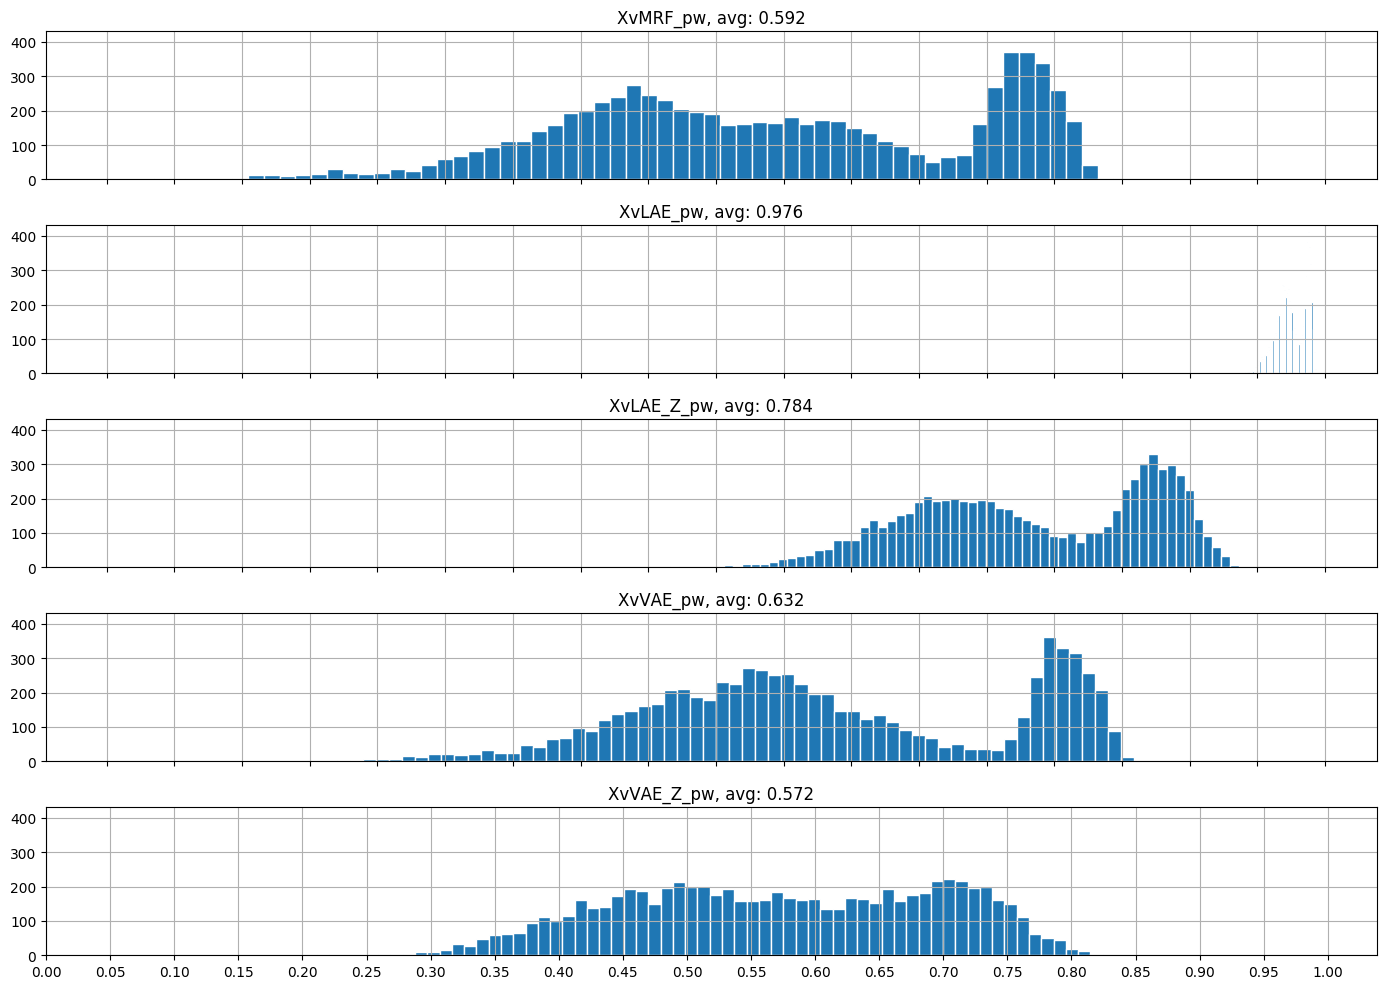

In [442]:
F, A = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(14, 10))
[(A[i].set_title(j+", avg: "+str(np.round(eval(j).mean(), 3))),
  A[i].hist(eval(j), bins=64, ec="w"))
  for i, j in enumerate([
    "XvMRF_pw", "XvLAE_pw", "XvLAE_Z_pw", "XvVAE_pw", "XvVAE_Z_pw"
  ])]
A[4].set_xticks(np.linspace(0, 1, 21))
[A[i].grid() for i in range(5)]
plt.tight_layout()
plt.show();

In [443]:
# input
X_PCA = PCA(2).fit(X.reshape((len(X), -1)))
X_pca_X = X_PCA.transform(X.reshape((len(X), -1)))
X_pca_dX = X_PCA.transform(dX.reshape((len(dX), -1)))
# latent
LAE_Z_PCA = PCA(2).fit(LAE_p_Z_X.reshape((len(X), -1)))
LAE_Z_pca_X = LAE_Z_PCA.transform(LAE_p_Z_X.reshape((len(X), -1)))
LAE_Z_pca_dX = LAE_Z_PCA.transform(LAE_p_Z_dX.reshape((len(dX), -1)))
VAE_Zm_PCA = PCA(2).fit(VAE_p_Zm_X.reshape((len(X), -1)))
VAE_Zm_pca_X = VAE_Zm_PCA.transform(VAE_p_Zm_X.reshape((len(X), -1)))
VAE_Zm_pca_dX = VAE_Zm_PCA.transform(VAE_p_Zm_dX.reshape((len(dX), -1)))
# output
LAE_ZD_PCA = PCA(2).fit(LAE_p_ZD_X.reshape((len(X), -1)))
LAE_ZD_pca_X = LAE_ZD_PCA.transform(LAE_p_ZD_X.reshape((len(X), -1)))
LAE_ZD_pca_dX = LAE_ZD_PCA.transform(LAE_p_ZD_dX.reshape((len(dX), -1)))
VAE_ZDm_PCA = PCA(2).fit(VAE_p_ZDm_X.reshape((len(X), -1)))
VAE_ZDm_pca_X = VAE_ZDm_PCA.transform(VAE_p_ZDm_X.reshape((len(X), -1)))
VAE_ZDm_pca_dX = VAE_ZDm_PCA.transform(VAE_p_ZDm_dX.reshape((len(dX), -1)))
MRF_PCA = PCA(2).fit(MRF_p_X.reshape((len(X), -1)))
MRF_pca_X = MRF_PCA.transform(MRF_p_X.reshape((len(X), -1)))
MRF_pca_dX = MRF_PCA.transform(MRF_p_dX.reshape((len(dX), -1)))

In [444]:
# visualize
hamm_params = {
  "alpha": 0.8, "lw": 0,
  "s": np.concatenate([[64], 2*np.ones(len(hamm)-1)])[::-1],
  "c": np.concatenate([np.array([[0.0, 0.0, 0.0, 1]]), cm.get_cmap("rainbow", len(hamm))(hamm/hamm.max())[1:]])[::-1]
}
dms_params = {
  "alpha": 0.8, "lw": 0,
  "s": np.concatenate([hamm_params["s"], 2*np.ones(len(dX))]),
  "c": np.concatenate([hamm_params["c"], np.tile(np.array([[0.0, 0.0, 0.0, 1]]), len(dX)).reshape((len(dX), 4))])
}

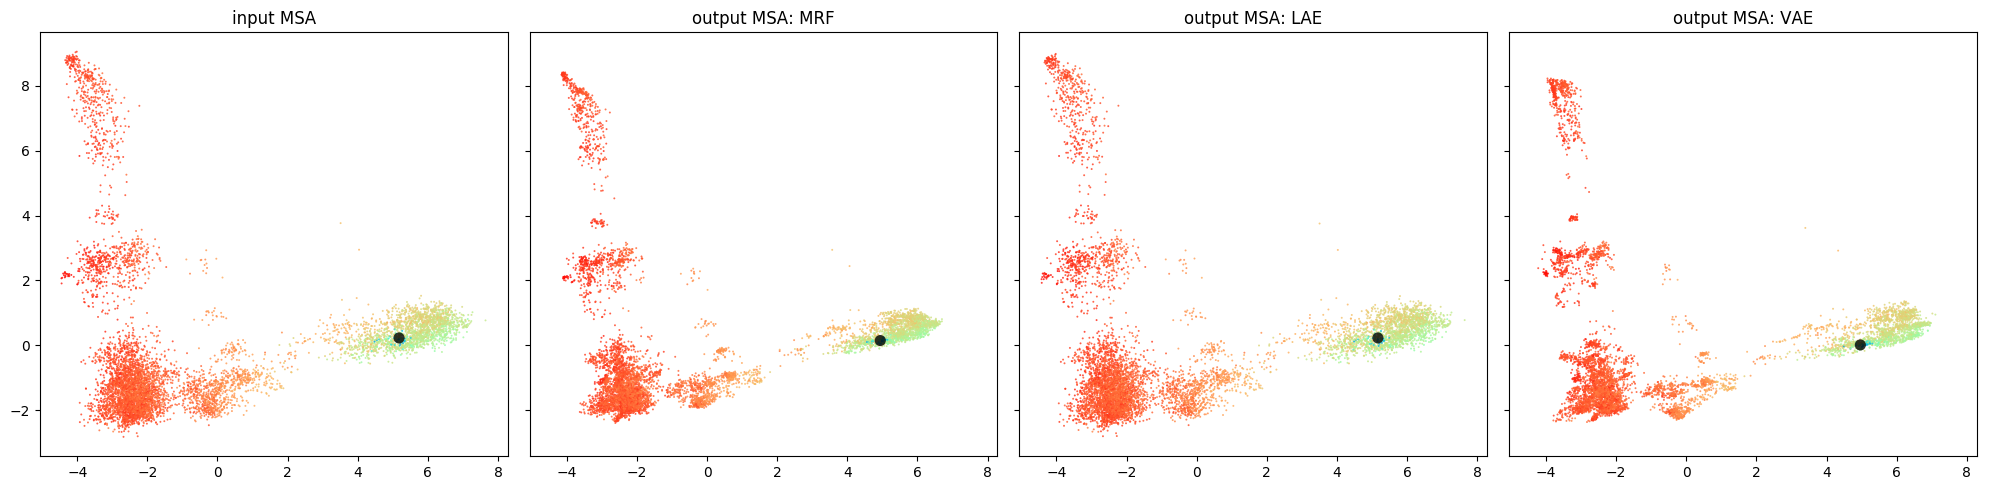

In [445]:
F, A = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))
A[0].scatter(X_pca_X[:, 0][::-1], X_pca_X[:, 1][::-1], **hamm_params)
A[1].scatter(MRF_pca_X[:, 0][::-1], MRF_pca_X[:, 1][::-1], **hamm_params)
A[2].scatter(LAE_ZD_pca_X[:, 0][::-1], LAE_ZD_pca_X[:, 1][::-1], **hamm_params)
A[3].scatter(VAE_ZDm_pca_X[:, 0][::-1], VAE_ZDm_pca_X[:, 1][::-1], **hamm_params)
[A[i].set_title(j) for i, j in enumerate(["input MSA", "output MSA: MRF", "output MSA: LAE", "output MSA: VAE"])]
plt.tight_layout()
plt.show();

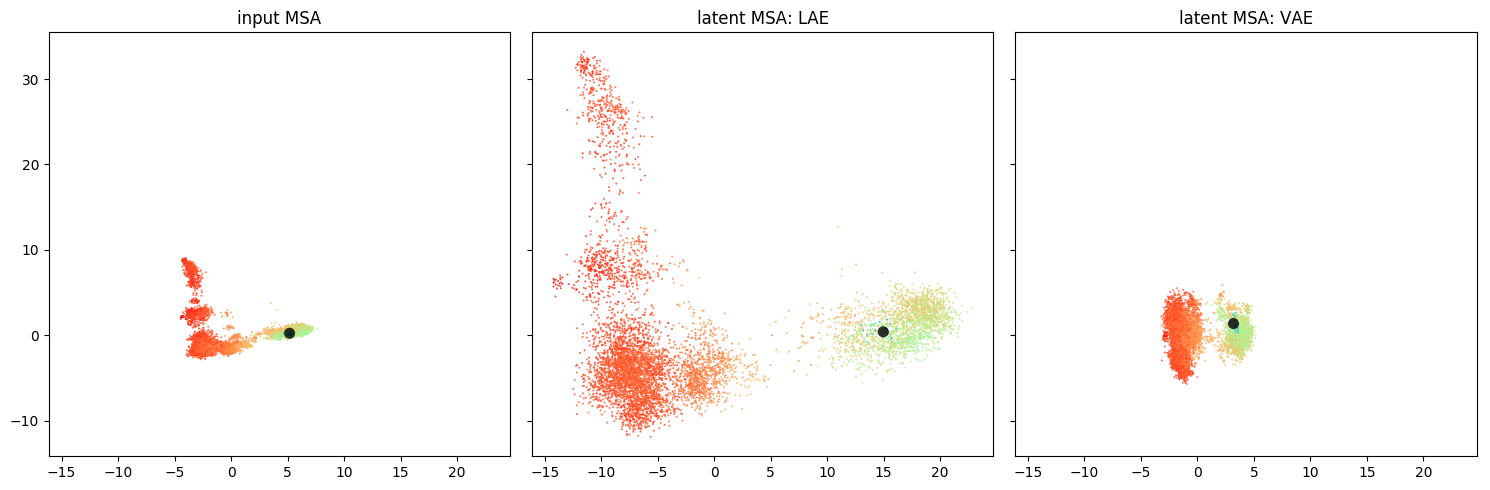

In [447]:
F, A = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
A[0].scatter(X_pca_X[:, 0][::-1], X_pca_X[:, 1][::-1], **hamm_params)
A[1].scatter(LAE_Z_pca_X[:, 0][::-1], LAE_Z_pca_X[:, 1][::-1], **hamm_params)
A[2].scatter(VAE_Zm_pca_X[:, 0][::-1], VAE_Zm_pca_X[:, 1][::-1], **hamm_params)
[A[i].set_title(j) for i, j in enumerate(["input MSA", "latent MSA: LAE", "latent MSA: VAE"])]
plt.tight_layout()
plt.show();

________________________________________________________________________________________________________________________________________

MSA redundancy

________________________________________________________________________________________________________________________________________

In [83]:
all_dY = {x: eval(x).copy() for x in ["i100", "i90", "i80", "i70", "i60", "i50"]}

In [101]:
mrf_con = np.array([float([z.split("|")[-2][7:] for z in y.index if z.startswith("MRF") and z.endswith("dX_p_dX")][0]) for y in all_dY.values()])
mrf_corr = np.array([float(y["meas_fit_avg"].iloc[19]) for y in all_dY.values()])
lae_con = np.array([float([z.split("|")[-2][7:] for z in y.index if z.startswith("LAE") and z.endswith("dX_p_dX")][0]) for y in all_dY.values()])
lae_corr = np.array([float(y["meas_fit_avg"].iloc[21]) for y in all_dY.values()])
vae_con = np.array([float([z.split("|")[-2][7:] for z in y.index if z.startswith("VAE") and z.endswith("dX_p_dX.KL")][0]) for y in all_dY.values()])
vae_corr = np.array([float(y["meas_fit_avg"].iloc[24]) for y in all_dY.values()])

In [102]:
# max pw ID, radius size
im = np.array([100, 90, 80, 70, 60, 50])
radii = 2**np.arange(4, 10)[::-1]
[print(x, y) for x, y in zip(all_dY.keys(), radii)];

i100 512
i90 256
i80 128
i70 64
i60 32
i50 16


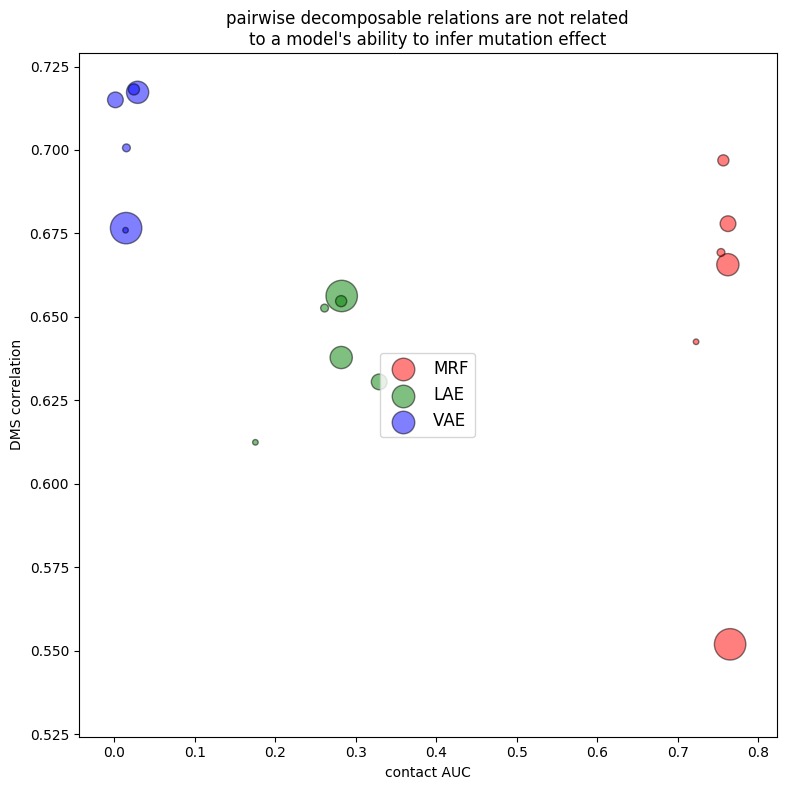

In [104]:
F, A = plt.subplots(1, 1, figsize=(8, 8))
A.scatter(mrf_con, mrf_corr, s=radii, lw=1, edgecolors="k", color="r", alpha=0.5, label="MRF")
A.scatter(lae_con, lae_corr, s=radii, lw=1, edgecolors="k", color="g", alpha=0.5, label="LAE")
A.scatter(vae_con, vae_corr, s=radii, lw=1, edgecolors="k", color="b", alpha=0.5, label="VAE")
A.set_title("pairwise decomposable relations are not related\nto a model's ability to infer mutation effect")
A.set_xlabel("contact AUC")
A.set_ylabel("DMS correlation")
plt.legend(loc="center", fontsize="large")
plt.tight_layout()
plt.show();

________________________________________________________________________________________________________________________________________

experimental PSSM

________________________________________________________________________________________________________________________________________

> VAE_par := {'enc': '(512,)', 'lat': '2048', 'dec': '(512,)', 'drop': '0.2', 'l2': '0.01'}

In [412]:
exp_cols = [c for c in dY.columns if any([c.startswith(x) for x in ["R_", "P_", "T_", "O_"]])]
exp_vals = {
  "val_"+c: np.hstack([
    dY[c].values.reshape((len(rs), 20))[rs_ng, :][msa["X_ng"], :],
    np.zeros(X.shape[1])[..., None]
  ])[None, ...] for c in exp_cols
}
exp_pssms = {
  "pssm_"+c: np.hstack([
    special.softmax(dY[c].values.reshape((len(rs), 20)), -1),
    np.zeros(len(rs))[..., None]
  ])[rs_ng, :][msa["X_ng"], :][None, ...] for c in exp_cols
}
exp_pssm_oh = {"pssm_"+c: np.eye(21)[np.argmax(exp_pssms["pssm_"+c], -1)] for c in exp_cols}
exp_pred = {"pred_"+c: VAE["ZDm"].predict(exp_pssm_oh["pssm_"+c]) for c in exp_cols}

In [422]:
exp_pssm_oh_hamm = pd.Series({x: (np.abs(y-ref).sum((1, 2))//2)[0] for x, y in exp_pssm_oh.items()})
print(f"experimental PSSM one-hot, Hamming distance to WT:\n{exp_pssm_oh_hamm}")

experimental PSSM one-hot, Hamming distance to WT:
pssm_R_amp_avg_39        228.0
pssm_R_amp_avg_156       229.0
pssm_R_amp_avg_625       211.0
pssm_R_amp_avg_2500      118.0
pssm_R_amp_r1_39         231.0
pssm_R_amp_r1_156        218.0
pssm_R_amp_r1_625        218.0
pssm_R_amp_r1_2500       112.0
pssm_R_amp_r2_39         233.0
pssm_R_amp_r2_156        231.0
pssm_R_amp_r2_625        213.0
pssm_R_amp_r2_2500       124.0
pssm_R_cefo              241.0
pssm_P_amp_ddG_stat      252.0
pssm_T_amox_MIC_score    227.0
pssm_O_amp_linear        241.0
dtype: float64


In [409]:
check = pd.DataFrame({
  **{x: y[:, :, :-1].flatten() for x, y in exp_vals.items()},
  **{x: y[:, :, :-1].flatten() for x, y in exp_pssms.items()},
  **{x: y[:, :, :-1].flatten() for x, y in exp_pred.items()},
  "pred_wt": VAE["ZDm"].predict(ref)[:, :, :-1].flatten()
})
check = check.corr("spearman")
check = check[[c for c in check.columns if check[c].isna().sum() != len(check)]]\
  .iloc[[i for i, c in enumerate(check.columns) if check[c].isna().sum() != len(check)]]

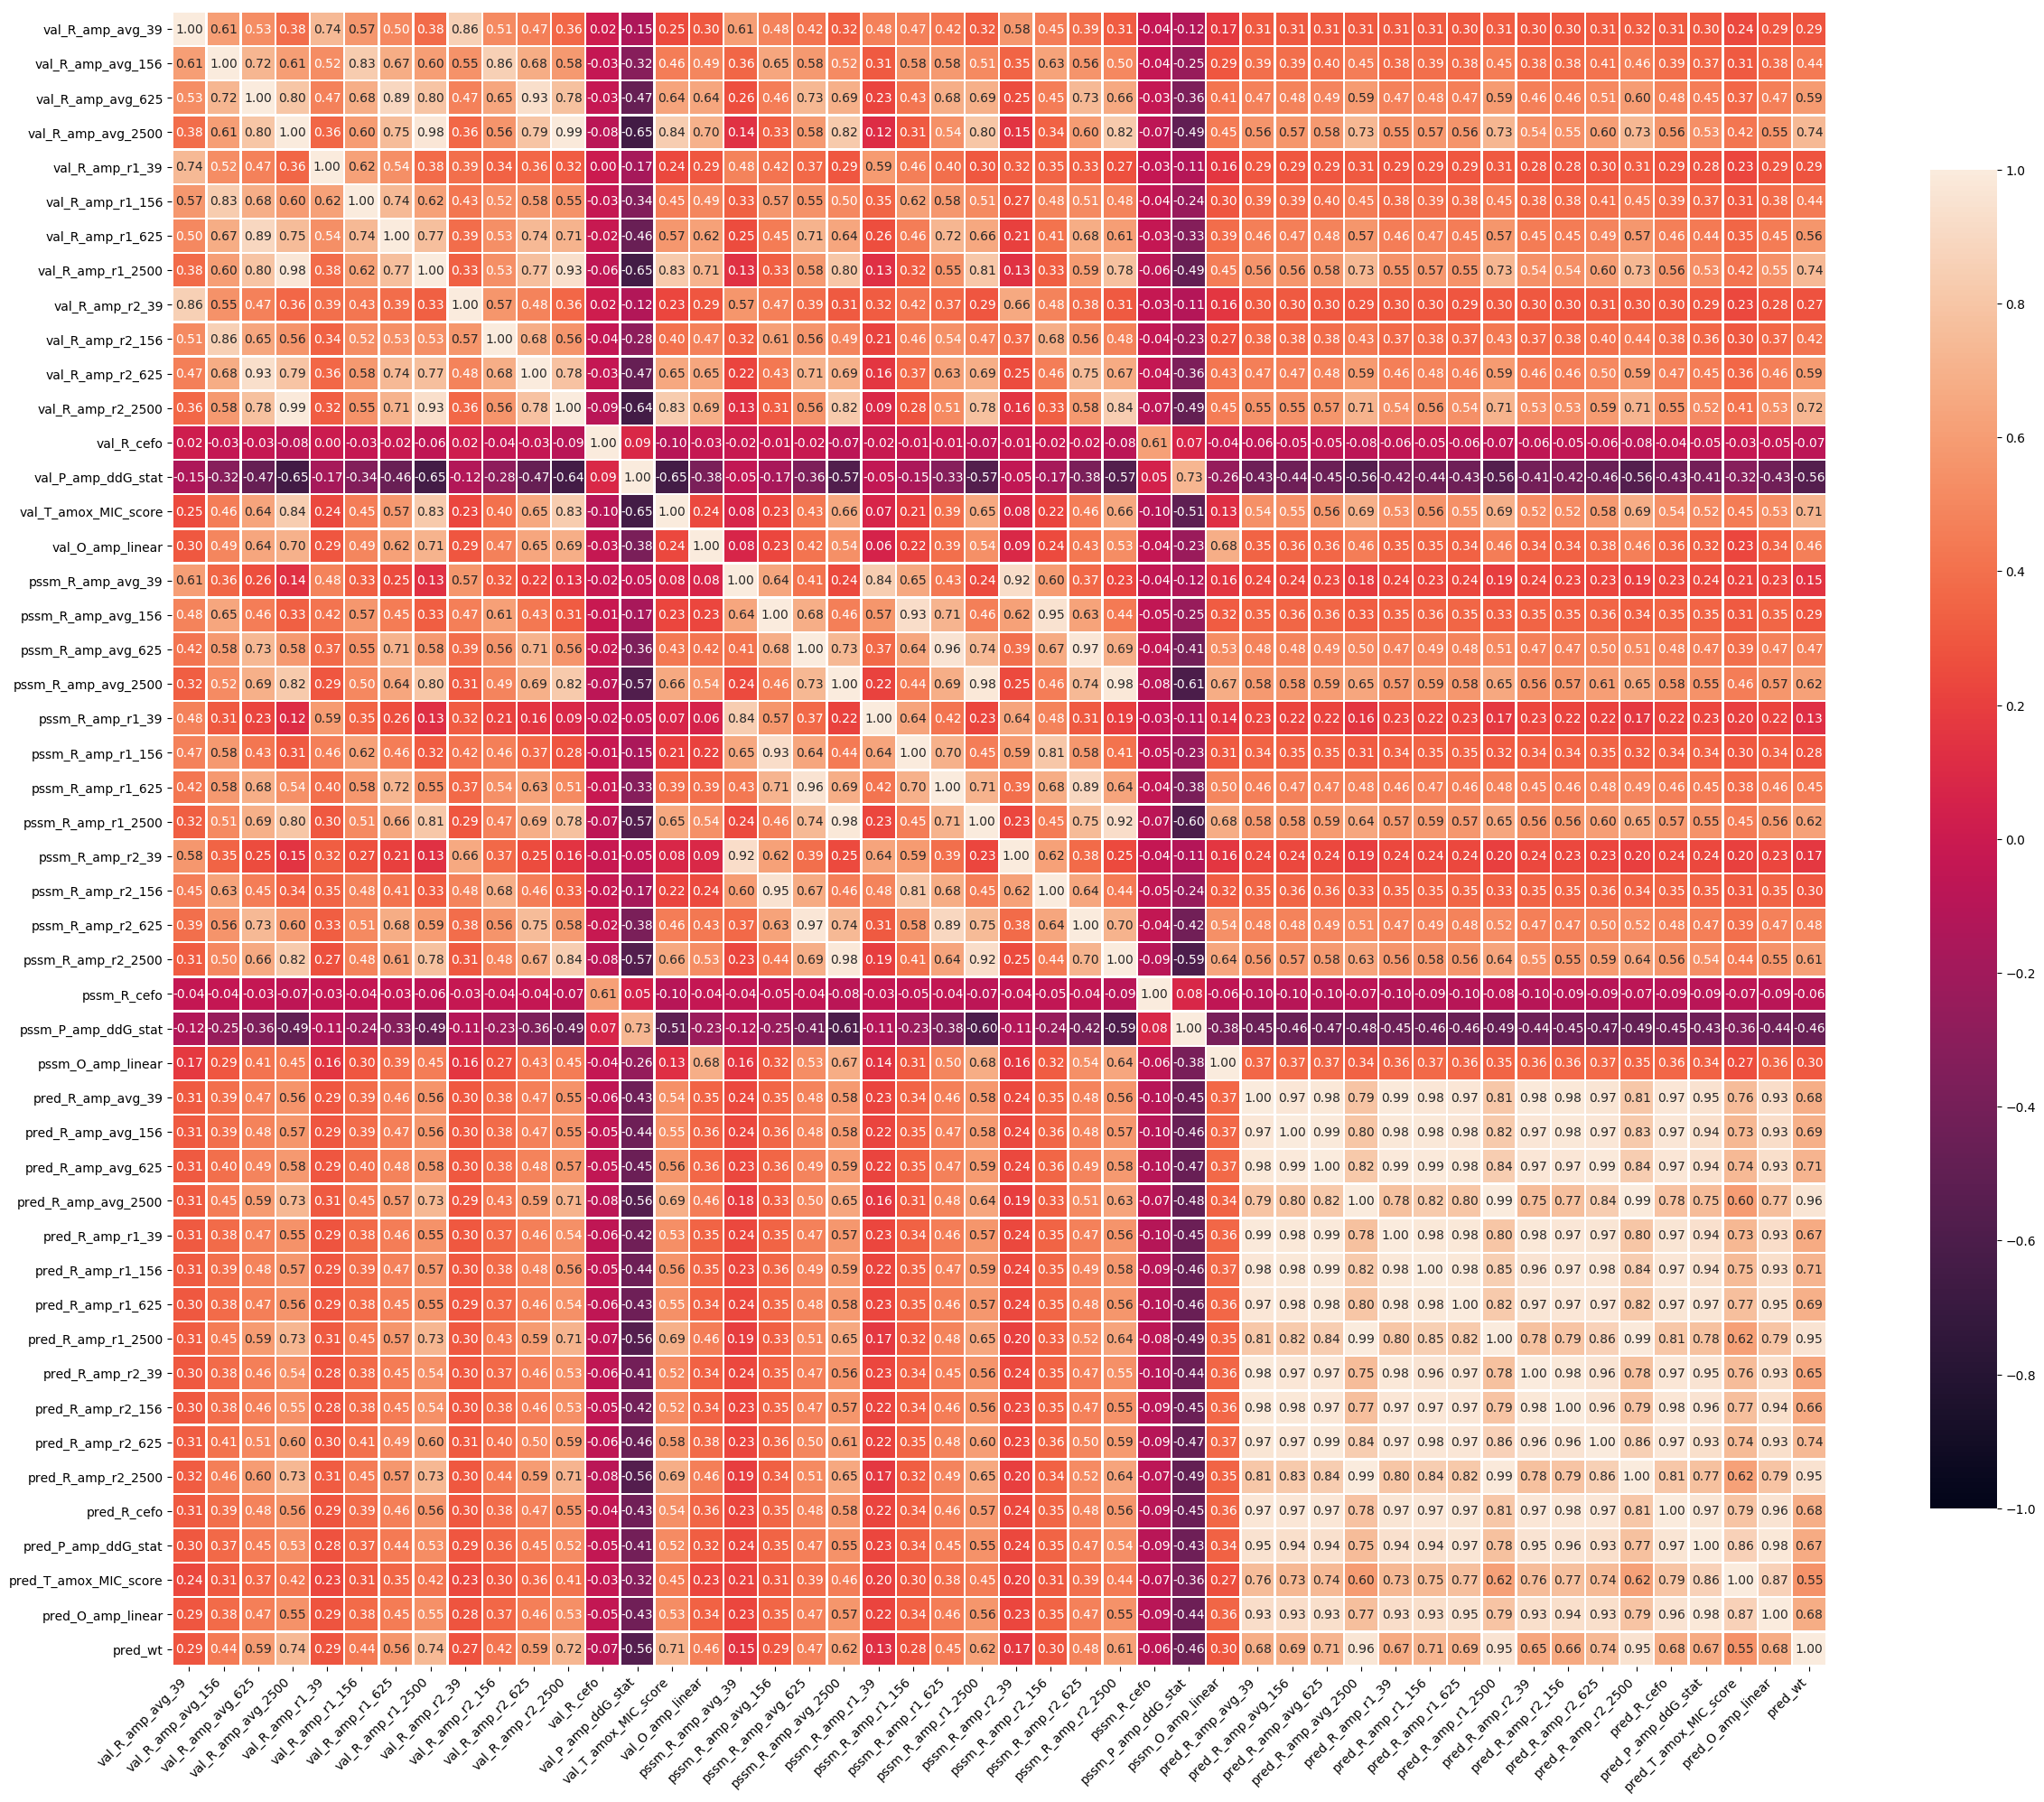

In [423]:
F, A = plt.subplots(1, 1, figsize=(25, 25))
# F, A = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(
  check, annot=True, fmt=".2f", vmin=-1, vmax=1, linecolor="w", linewidths=1, square=True,
  cbar_kws={"ticks": np.linspace(-1, 1, num=11), "shrink": 0.6}, ax=A
)
A.set_xticklabels(A.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
# plt.savefig(_fig_dir+"exp_pssm.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

________________________________________________________________________________________________________________________________________

functional annotations

________________________________________________________________________________________________________________________________________

In [42]:
fcn_num = np.array(list(dict(zip(*np.unique(fcns, return_counts=True))).items()))
fcn_t10 = fcn_num[np.argsort(fcn_num[:, 1].astype("int"))[::-1], 0][1:11]

In [43]:
fcn_t10_lc = dict(zip(fcn_t10, [colors.rgb2hex(c) for c in cm.get_cmap("tab10")(np.linspace(0, 1, 10))]))
fcn_t10_lc.update({"other": "#c0c0c0", "WT": "#000000"})

In [44]:
fcn_col = [fcn_t10_lc["WT"]]
for f in fcns[1:]:
  try: fcn_col.append(fcn_t10_lc[f])
  except: fcn_col.append(fcn_t10_lc["other"])
fcn_col = np.array(fcn_col)

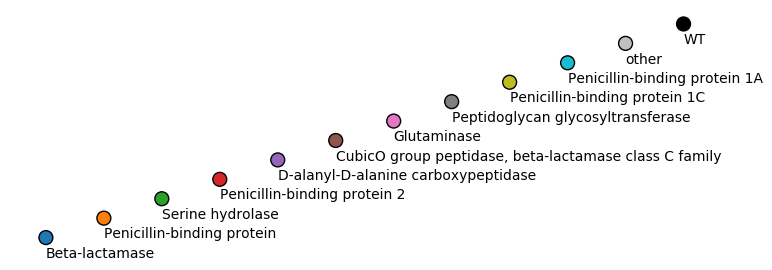

In [47]:
F, A = plt.subplots(1, 1, figsize=(8, 2.8))
_idx = np.arange(12)
A.scatter(_idx, _idx, c=list(fcn_t10_lc.values()), edgecolor="k", s=100)
[A.text(x, y-1, z) for z, x, y in zip(list(fcn_t10_lc.keys()), _idx, _idx)]
A.set_xticks([])
A.set_yticks([])
[A.spines[x].set_visible(False) for x in ["left", "right", "bottom", "top"]]
plt.tight_layout()
plt.show();

In [232]:
p_Zm_qa = VAE["Zm"].predict(X_qa)

In [243]:
_par = {
  "s": np.concatenate([[512], np.repeat(0.5, len(X)-len(qa)-1), np.repeat(2, len(qa))]),
#   "s": np.concatenate([[512], np.repeat(0.5, len(X)-len(qa)-1), np.repeat(2, len(qa))])[:len(msa["X"])],
#   "s": np.concatenate([[512], np.repeat(0.5, len(X)-1), np.repeat(2, len(qa))]),
#   "x": np.concatenate([p_Zm_X[:, 0], p_Zm_qa[:, 0]]),
#   "y": np.concatenate([p_Zm_X[:, 1], p_Zm_qa[:, 1]]),
  "x": p_Zm_X[:, 0],#[:len(msa["X"])],
  "y": p_Zm_X[:, 1],#[:len(msa["X"])],
  "alpha": 0.5
}

In [234]:
_par_fcn = {
#   "c": np.concatenate([["g"], np.tile("b", len(X)-1)])[:len(msa["X"])], **_par
#   "c": np.concatenate([["g"], np.tile("b", len(X)-1), np.tile("r", len(qa))]), **_par
  "c": np.concatenate([["g"], np.tile("b", len(X)-len(qa)-1), np.tile("r", len(qa))]), **_par
}
_par_hamm = {
  "c": np.concatenate([["k"],
    [colors.rgb2hex(x) for x in cm.get_cmap("viridis_r", len(hamm)+len(qa_hamm))(np.concatenate([hamm, qa_hamm])/hamm.max())[1:]]
#     [colors.rgb2hex(x) for x in cm.get_cmap("viridis_r", len(hamm))(hamm/hamm.max())[1:]]
  ]), **_par
}

In [286]:
hamm_params = {
  "alpha": 0.7, "lw": 0.05,
  "s": np.concatenate([[128], 4*np.ones(len(hamm)-1)]),
  "c": np.concatenate([np.array([[0.0, 0.0, 0.0, 1]]), cm.get_cmap("viridis", len(hamm))(hamm/hamm.max())[1:]])
}

In [ ]:
F, A = plt.subplots(1, 1, figsize=(10, 3))
_idx = np.arange(len(lc))
A.scatter(_idx, _idx, c=list(lc.values()), edgecolor="k", s=100)
[A.text(x, y-1, z) for z, x, y in zip(list(lc.keys()), _idx, _idx)]
A.set_xticks([])
A.set_yticks([])
[A.spines[x].set_visible(False) for x in ["left", "right", "bottom", "top"]]
plt.tight_layout()
plt.show();

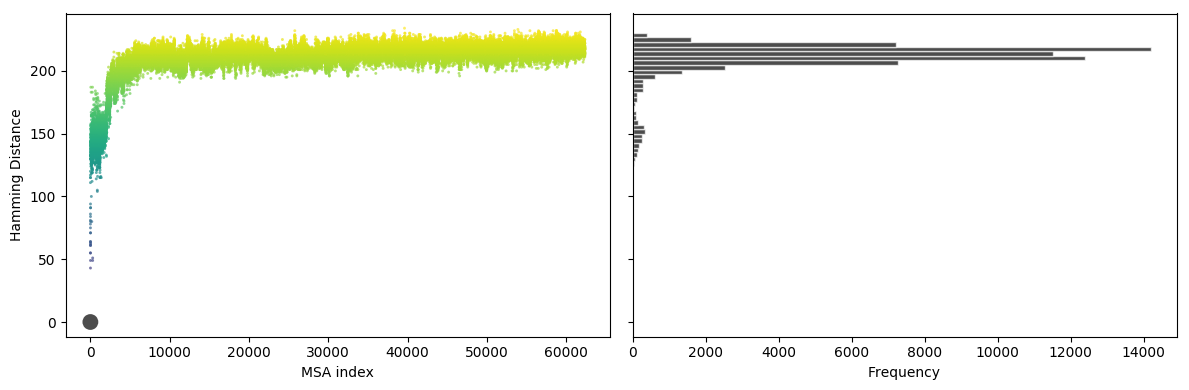

In [287]:
# Hamming Distance vs Reference Sequence
F, A = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
A[0].scatter(np.arange(len(hamm)), hamm, **hamm_params)
A[1].hist(hamm, orientation="horizontal", bins=64, color="k", alpha=0.7, ec="w")
A[0].set_xlabel("MSA index")
A[1].set_xlabel("Frequency")
A[0].set_ylabel("Hamming Distance")
plt.tight_layout()
# plt.savefig("/".join(["results", _F, _F+".hamm.png"]), format="png", bbox_inches="tight", pad_inches=0.2, dpi=300)
plt.show();

In [ ]:
F, A = plt.subplots(1, 1, figsize=(12, 2.5))
A.scatter(np.arange(len(hamm)), labels, c=colors, alpha=0.7, s=np.concatenate([[64], 2*np.ones(len(hamm)-1)]))
A.set_xlabel("MSA index")
plt.tight_layout()
plt.show()

In [ ]:
F, A = plt.subplots(1, 1, figsize=(12, 2.5))
A.scatter(labels, hamm, c=colors, lw=0.05, edgecolor="k", alpha=0.8, s=np.concatenate([[128], 16*np.ones(len(hamm)-1)]))
A.set_xticks([])
A.set_ylabel("Hamming Distance")
plt.tight_layout()
plt.show()

________________________________________________________________________________________________________________________________________

contacts

________________________________________________________________________________________________________________________________________

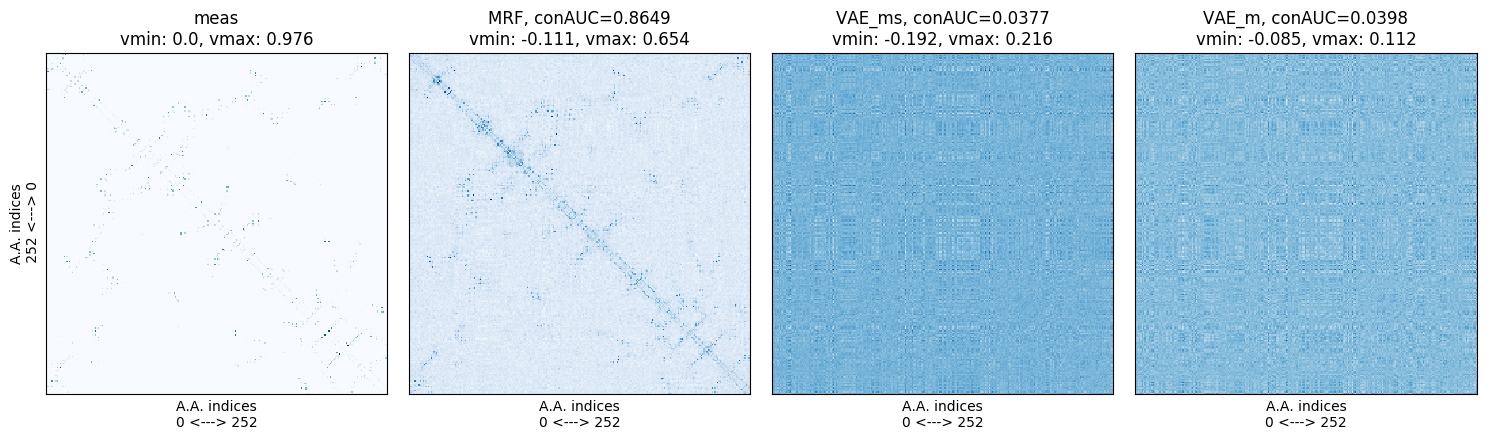

In [97]:
# visualize
F, A = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 5))
[(A[i].set_title(x+z+"\nvmin: "+str(np.round(np.min(y), 3))+", vmax: "+str(np.round(np.max(y), 3))),
  A[i].imshow(y, cmap="Blues"), A[i].set_xticks([]), A[i].set_yticks([]))
  for i, (x, y, z) in enumerate(zip(
    ["meas", "MRF", "VAE_ms", "VAE_m"], [con, MRF_con, VAE_ms_con, VAE_m_con],
    [""]+[", conAUC="+x for x in [MRF_conAUC, VAE_ms_conAUC, VAE_m_conAUC]]
))]
A[0].set_ylabel("A.A. indices\n "+str(len(con))+" <---> 0")
[A[i].set_xlabel("A.A. indices\n0 <---> "+str(len(con))) for i in range(4)]
plt.tight_layout()
plt.show();

________________________________________________________________________________________________________________________________________

other

________________________________________________________________________________________________________________________________________